In [107]:
import numpy
from scipy import special

from matplotlib import pyplot
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict

import functools
import operator

pyplot.style.use('ggplot')
%matplotlib inline

## 事前確率と事後確率

### Factorial
$ n! = n * n(-1) \dots 2 * 1 $

### Combination
$ nCr = \frac{n!}{r!} $

### Bernoulli
$ bern(n; \theta) = nCr * \theta^r * (1-\theta)^{n-r} $



## 事後確率

$ p(w_i|\pmb{x^{(n)}}) = \frac{\pi_i \theta_i^r (1 - \theta_i)^{n-r} }{\sum_{j=1}^{3}{\pi_j \theta_j^r (1 - \theta_j)^{n-r}}} $


The result of experiment seems to be unstable...


## ベイズ学習

系列 $ \mathbf{x}^{(n)} $ が与えられたとき， $ P(w_i|\mathbf{x^{(n)}}) $ を直接計算するのではなく，逐次的に事後確率を更新していく．

\begin{align}
P(w_i|\mathbf{x}^{(n)}) = \frac{P(x_n|w_i)}{\sum_{j=1}^{3} P(w_j| \mathbf{x}^{(n-1)})P(x_n|w_j)} P(w_i|\mathbf{x}^{(n-1)})
\end{align}


直接計算とはこういうこと（多分）．

$ P(w_i|\mathbf{x^{(n)}}) = \Pi_{t=1}^{n} P(w_i|x_n) $

In [10]:
def factorial(k):
    return 1 if k <= 1 else k * factorial(k-1)

def c(n, r):
    return factorial(n) / (factorial(n-r) * factorial(r))

def bern(n, theta):
    return [c(n, r)*theta**r * (1-theta)**(n-r) for r in range(n+1)]

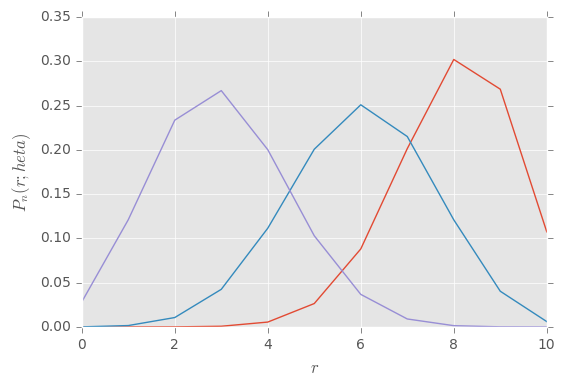

In [11]:
# 図2.2

# thetaの値はテキストでは既知ではない(見た限り)ので適当に決め打ちした
probabilities = bern(n=10, theta=0.8)
pyplot.plot(probabilities)
probabilities = bern(n=10, theta=0.6)
pyplot.plot(probabilities)
probabilities = bern(n=10, theta=0.3)
pyplot.plot(probabilities)

pyplot.xlabel("$r$")
pyplot.ylabel("$P_n(r; \theta)$")

In [13]:
# sampler
def choice(n, prob=0.8):
    return "".join("H" if numpy.random.random() < prob else "T" for _ in range(n))

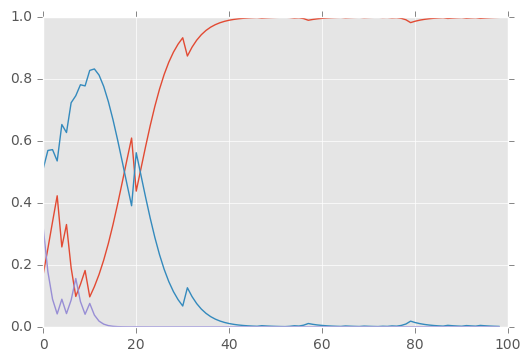

In [17]:
num_iter = 100
prior = [[0, 0, 0] for _ in range(num_iter)]
prior[0] = [0.1, 0.4, 0.5]
pi = [0.8, 0.6, 0.3]

samples = choice(num_iter, 0.8)

posterior_history = list()

for t in range(1, num_iter):
    if samples[t] == 'H':
        for j in range(3):
            norm = sum(prior[t-1][k] * pi[k] for k in range(3))
            prior[t][j] = prior[t-1][j] * pi[j] / norm
            
    else:
        for j in range(3):
            norm = sum(prior[t-1][k] * (1-pi[k]) for k in range(3))
            prior[t][j] = prior[t-1][j] * (1-pi[j]) / norm
        
    posterior_history.append(prior[t])
    
results = numpy.array(posterior_history)
pyplot.plot(results[:, 0])
pyplot.plot(results[:, 1])
pyplot.plot(results[:, 2])

## ベイズ決定則

In [8]:
def p_with_cond(n, r, theta, pi):
    return pi * theta ** r * (1-theta) ** (n-r)


def p_with_marginalized(n, r):
    return sum([p_with_cond(n, r, THETA[i], PI[i]) for i in range(3)])


def p(n, r, theta, pi):
    return p_with_cond(n, r, theta, pi) / p_with_marginalized(n, r)

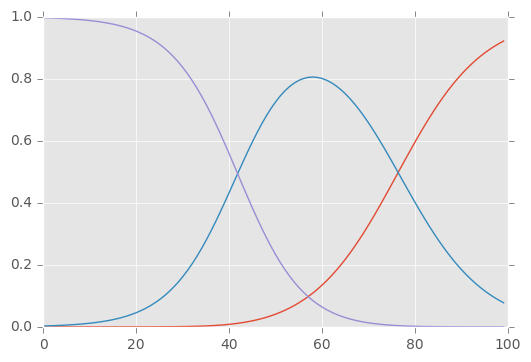

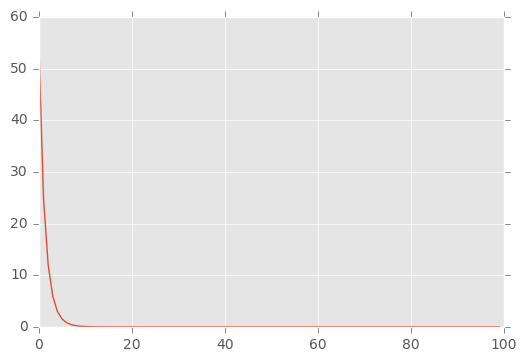

In [4]:
THETA = [0.8, 0.6, 0.3]
PI = [0.1, 0.4, 0.5]

n = 10
pyplot.plot([p(n, r, THETA[0], PI[0]) for r in numpy.linspace(0,n+1,100)])
pyplot.plot([p(n, r, THETA[1], PI[1]) for r in numpy.linspace(0,n+1,100)])
pyplot.plot([p(n, r, THETA[2], PI[2]) for r in numpy.linspace(0,n+1,100)])
pyplot.show()

pyplot.plot([sum([min([1 - p(n, r, THETA[i], PI[i]) for i in range(3)]) * p_with_marginalized(n, r) for r in numpy.linspace(0,n+1,100)]) for n in range(100)])

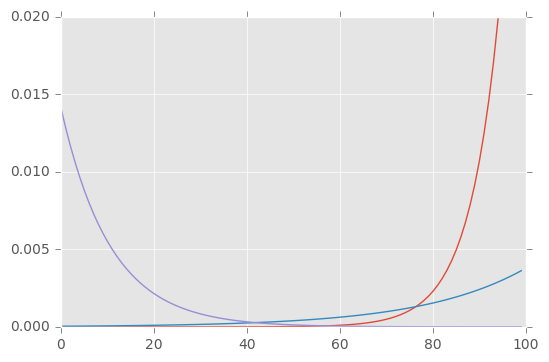

In [5]:
line1, line2, line3 = [], [], []
R = numpy.linspace(0, 11, 100)

for r in R:
    line1.append(PI[0] * THETA[0]** r * (1-THETA[0]) ** (10-r))
    line2.append(PI[1] * THETA[1]** r * (1-THETA[1]) ** (10-r))
    line3.append(PI[2] * THETA[2]** r * (1-THETA[2]) ** (10-r))

pyplot.plot(line1)
pyplot.plot(line2)
pyplot.plot(line3)

pyplot.ylim(0,0.02)
pyplot.show()

In [7]:
for r in range(11):
    print("表が%s回なら%s" % (r, numpy.argmax([PI[i] * THETA[i] ** r * (1-THETA[i]) ** (10-r) for i in range(3)])))

表が0回なら2
表が1回なら2
表が2回なら2
表が3回なら2
表が4回なら2
表が5回なら1
表が6回なら1
表が7回なら1
表が8回なら1
表が9回なら0
表が10回なら0


# パラメータ推定

In [45]:
def B(alpha, beta):
    return special.gamma(alpha) * special.gamma(beta) / special.gamma(alpha + beta)


def Be(alpha, beta, theta):
    return theta ** (alpha - 1) * (1-theta) ** (beta - 1) / B(alpha, beta)


def Dir(alpha, theta):
    prod = functools.partial(functools.reduce, operator.mul)
    coefficient = special.gamma(sum(alpha)) / prod(map(special.gamma, alpha))
    return coefficient * prod([theta[i] ** alpha[i] for i in range(len(alpha))])

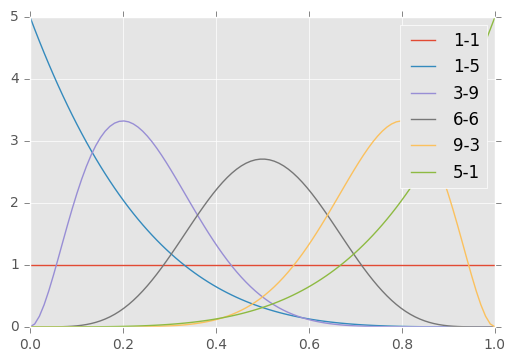

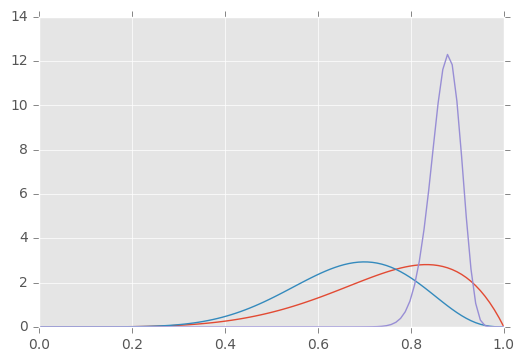

In [46]:
params = [
    (1, 1),
    (1, 5),
    (3, 9),
    (6, 6),
    (9, 3),
    (5, 1)
]


for param in params:
    pyplot.plot([theta for theta in numpy.linspace(0, 1, 100)], [Be(param[0], param[1], theta) for theta in numpy.linspace(0, 1, 100)], label="%d-%d" % (param))

pyplot.legend()
pyplot.show()

pyplot.plot([theta for theta in numpy.linspace(0, 1, 100)], [Be(6, 2, theta) for theta in numpy.linspace(0, 1, 100)])
pyplot.plot([theta for theta in numpy.linspace(0, 1, 100)], [Be(8, 4, theta) for theta in numpy.linspace(0, 1, 100)])
pyplot.plot([theta for theta in numpy.linspace(0, 1, 100)], [Be(89, 13, theta) for theta in numpy.linspace(0, 1, 100)])

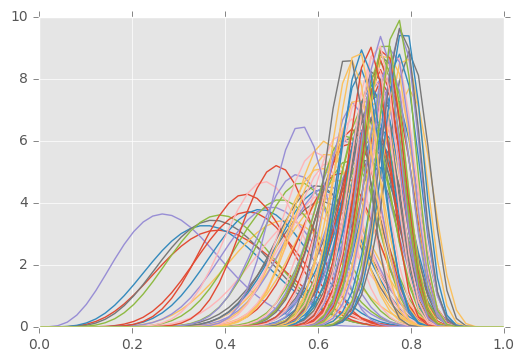

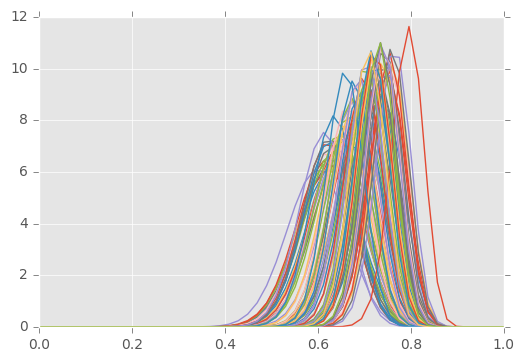

In [47]:
fig = pyplot.figure()
fig_list = list()
theta = 4/5


for n in range(3, 100):
    x = [numpy.random.random() < theta for _ in range(n)]
    a = x.count(True)+3
    b = x.count(False)+9
    pyplot.plot(*zip(*[(theta, Be(a, b, theta)) for theta in numpy.linspace(0, 1, 50)]))

pyplot.show()

fig = pyplot.figure()
fig_list = list()
theta = 4/5


for n in range(3, 100):
    x = [numpy.random.random() < theta for _ in range(n)]
    a = x.count(True)+31
    b = x.count(False)+21
    pyplot.plot(*zip(*[(theta, Be(a, b, theta)) for theta in numpy.linspace(0, 1, 50)]))

pyplot.show()

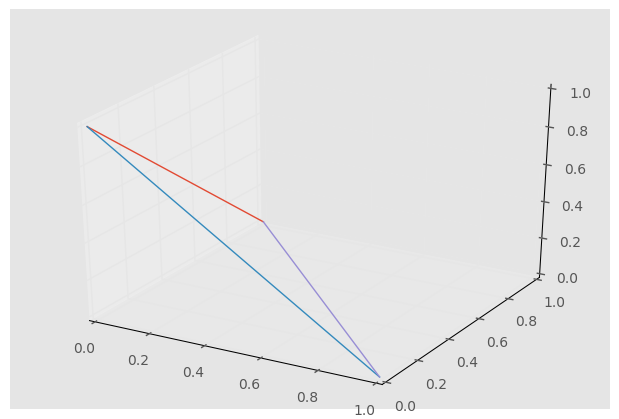

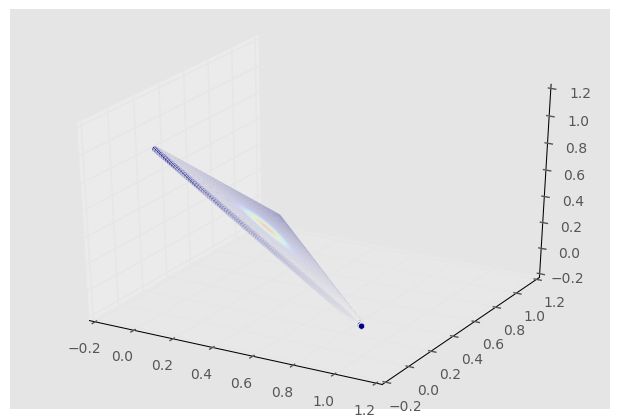

In [48]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.plot([0, 0], [1, 0],[0, 1])
ax.plot([1, 0], [0, 0],[0, 1])
ax.plot([1, 0], [0, 1],[0, 0])
pyplot.show()

alpha = [10, 10, 10]
theta = [(i, j, 1-i-j) for i in numpy.linspace(0, 1, 100) for j in numpy.linspace(0, 1 - i, 100)]
prob = numpy.array([(theta_i[0], theta_i[1], theta_i[2], Dir(alpha, theta_i)) for theta_i in theta])

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(prob[:, 0], prob[:, 1], prob[:, 2], c=cm.jet(prob[:, 3]))
pyplot.show()

# 教師付き学習と教師なし学習

$ P(w_i|v_k) = \frac{\pi_i \theta_{i_k}}{\sum_{j=1}^{3}\pi_j \theta_{j_k}} $

$ \hat{\pi_i} = \frac{1}{n} \sum_{k=1}^m r_k P(w_i|v_k) $

$ log P(\bf{x}) = \sum_{k=1}^m r_k \log p(v_k) $

In [51]:
def p(i, pi, THETA, r):
    if r == 0:
        return pi[i] * THETA[i] / sum([pi[j] * THETA[j] for j in range(3)])
    else:
        return pi[i] * (1-THETA[i]) / sum([pi[j] * (1-THETA[j]) for j in range(3)])


def update_pi(i, pi, THETA, R):
    return (R[0] * p(i, pi, THETA, 0) + R[1] * p(i, pi, THETA, 1)) / sum(R)


def p_v(pi, THETA, r):
    if r == 0:
        return sum([pi[i] * THETA[i] for i in range(3)])
    else:
        return sum([(pi[i] * (1-THETA[i])) for i in range(3)])
    

def likelihood(R, pi, THETA):
    return R[0] * (numpy.log(p_v(pi, THETA, 0))) + R[1] * (numpy.log(p_v(pi, THETA, 1)))

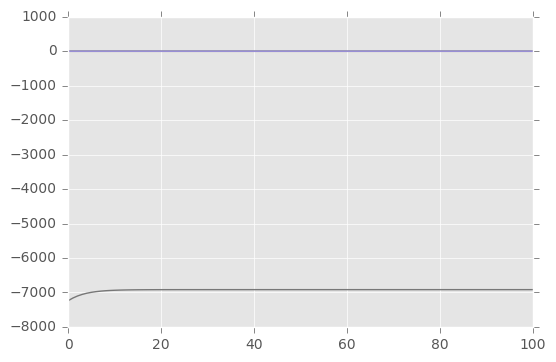

In [52]:
pi = [0.3, 0.5, 0.2]
THETA = [0.8, 0.6, 0.3]
R = [4746, 5254]


results = [pi]
likelihoods = [likelihood(R, pi, THETA)]

for _ in range(100):
    tmp = list()
    tmp.append(update_pi(0, pi, THETA, R))
    tmp.append(update_pi(1, pi, THETA, R))
    tmp.append(update_pi(2, pi, THETA, R))
    results.append(tmp)
    likelihoods.append(likelihood(R, tmp, THETA))
    pi = tmp


results = numpy.array(results)
pi_1 = results[:, 0]
pi_2 = results[:, 1]
pi_3 = results[:, 2]

pyplot.plot(pi_1)
pyplot.plot(pi_2)
pyplot.plot(pi_3)

pyplot.plot(likelihoods)

# マルコフモデル

### 前向きアルゴリズム

* 得られた観測値が生成される確率


パラメータ

- サイコロの種類 $ c $
- 目の数 $ m $ ( $ v \in \{ 表，裏 \} $ )

\begin{align}
  c = 3 \\
  m = 2
\end{align}


観測された系列

\begin{align}
\mathbf{x} = v_1 v_2 v_1
\end{align}


### 後ろ向きアルゴリズム

\begin{align}
\beta_n (i) = 1 \\
\beta_t (i) = \sum_{j=1}^{c} a_{i j} b(w_j, x_{t+1} ) \beta{t+1} (j)
\end{align}

\begin{align}
p ( \mathbf(x) ) = \sum_{i=0}^c \rho_i b(w_i, x_1) \beta_1 (i)
\end{align}

In [74]:
@functools.lru_cache()
def a(i, j) -> "あるサイコロを取り出した後にサイコロを取り出す確率":
    return A[i, j]


@functools.lru_cache()
def b(i:"サイコロの種類", t:"試行回数の添字") -> "あるサイコロを選んだときにそれぞれの目が出る確率":
    return B[i, x[t]]


@functools.lru_cache()
def alpha(t:"試行回数の添字", j:"n回目に出すサイコロの種類") -> "alpha_n(j)の確率":
    if t == 0:
        return rho[j] * b(j, t)
    else:
        return sum(alpha(t-1, i) * a(i, j)  for i in range(len(A))) *  b(j, t)
    
    
@functools.lru_cache()
def beta(t, i):
    if t == len(x)-1:
        return 1
    else:
        return sum(a(i, j) * b(j, t+1) * beta(t+1, j) for j in range(len(A)))

In [77]:
A   = numpy.asarray([[0.1, 0.7, 0.2], [0.2, 0.1, 0.7], [0.7, 0.2, 0.1]])
B   = numpy.asarray([[0.9, 0.1], [0.6, 0.4], [0.1, 0.9]])
rho = numpy.asarray([1/3, 1/3, 1/3])
x   = [0, 1, 0]


# feedforward
print(sum(alpha(2, i) for i in range(3)))

# backforward
print(sum(rho[i] * b(i, 0) * beta(0, i) for i in range(len(A))))

0.173373333333
0.173373333333


### ビタービアルゴリズム

* もっともあり得るサイコロの組み合わせ

* 何を出力するんだ...?
  - サイコロの種類の系列なはず
  - そのサイコロの系列はどうやって保存するんだ
    - 前向きアルゴリズムをただただmaxすれば良いってわけではなかったな

In [79]:
@functools.lru_cache()
def psi(t:"試行回数の添字", j:"n回目に出すサイコロの目の添字") -> "alpha_n(j)の確率":
    if t == 0:
        return rho[j] * b(j, t)
    else:
        return max(psi(t-1, i) * a(i, j)  for i in range(3)) *  b(j, t)
    

@functools.lru_cache()
def Psi(t:"試行回数の添字", j:"n回目に出すサイコロの目の添字"): 
    if t == 0:
        return 0
    else:
        return numpy.argmax([psi(t-1, i) * a(i, j) for i in range(3)])

In [82]:
%%time

x = [int(numpy.random.random() >= 0.5) for _ in range(100)]
numpy.argmax([psi(10, i) for i in range(3)])

CPU times: user 200 µs, sys: 9 µs, total: 209 µs
Wall time: 209 µs


### バウム・ウェルチアルゴリズム


\begin{align}
\hat{a}_{i j} = \frac{\sum_{t=1}^{n-1} \alpha_t (i) a_{i j} b(w_j, x_{t+1}) \beta_{t+1} (j) }{\sum_{t=1}^{n-1} \alpha_t (i) \beta_t (i)}
\end{align}

\begin{align}
\delta (x_t, v_k) = \begin{cases}
    1 & if & x_t = v_k \\
    0 & otherwise
\end{cases}
\end{align}

\begin{align}
\hat{b}_{j k} = \frac{\sum_{t=1}^{n} \delta(x_t, v_k) \alpha_t (i) \beta_{t} (j) }{\sum_{t=1}^{n} \alpha_t (i) \beta_t (i)}
\end{align}

\begin{align}
\hat{\rho_i} = \frac{\alpha_1 (i) \beta_1 (i)}{\sum_{j=1}^{c} \alpha_n (j)}
\end{align}

In [84]:
def delta(t, k):
    return 1 if x[t] == k else 0


def update_a(i, j):
    numerator = 0
    denominator = 0
    
    for t in range(0, n-1):
        numerator += alpha(t, i) * a(i, j) * b(j, t+1) * beta(t+1, j)
        denominator += alpha(t, i) * beta(t, i)
        
    return numerator / denominator


def update_b(j, k):
    numerator = 0
    denominator = 0
    
    for t in range(0, n):

        numerator += delta(t, k) * alpha(t, j) * beta(t, j)
        denominator += alpha(t, j) * beta(t, j)
        
    return numerator / denominator


def update_rho(i):
    numerator = alpha(0, i) * beta(0, i)
    denominator = 0
    
    for j in range(len(A)):
        denominator += alpha(n-1, j)

    return numerator / denominator

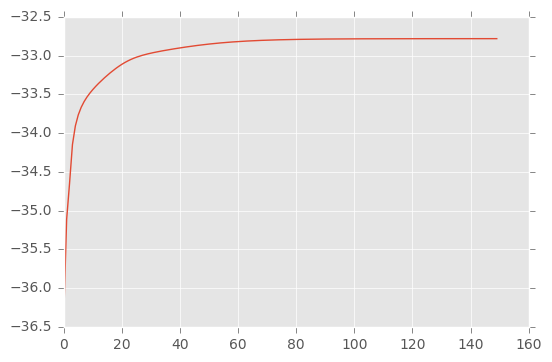

In [88]:
A   = numpy.asarray([[0.7, 0.2, 0.1], [0.1, 0.7, 0.2], [0.2, 0.1, 0.7]])
B   = numpy.asarray([[0.9, 0.1], [0.6, 0.4], [0.1, 0.9]])
rho = numpy.asarray([1, 0, 0])


# 終わらない
x = list(map(lambda x: x-1, [1,1,1,1,2,1,1,2,2,2,1,1,1,2,2,1,1,1,1,2,1,2,1,2,2,1,2,1,2,1,2,2,1,2,1,2,1,2,2,1,2,1,1,1,2,2,2,1,1,1]))


n = len(x)

A_new   = numpy.zeros((3, 3))
B_new   = numpy.zeros((3, 2))
rho_new = numpy.zeros(3)


alpha.cache_clear()
beta.cache_clear()
a.cache_clear()
b.cache_clear()

update_rho(0)


result = list()

for _ in range(150):

    alpha.cache_clear()
    beta.cache_clear()
    a.cache_clear()
    b.cache_clear()

    for i in range(len(A)):
        for j in range(len(A[0])):
            A_new[i, j] = update_a(i, j)
        
    for j in range(len(B)):
        for k in range(len(B[0])):            
            B_new[j, k] = update_b(j, k)
        
    for i in range(len(rho)):
        rho_new[i] = update_rho(i)
        
    result.append(numpy.log(sum(rho[i] * b(i, 0) * beta(0, i) for i in range(len(A)))))
        

    A = A_new
    B = B_new
    rho = rho_new
    
pyplot.plot(result)

# 混合ガウス分布

\begin{align}
p(x | w_i) = \frac{1}{\sqrt{2 \pi} \sigma_i } \exp{ [ - \frac{1}{2 \sigma_i^2 } (x- \mu_i ) ^2 ] }
\end{align}

In [91]:
import math

In [92]:
def p_x(x, wi, theta):
    numerator = numpy.exp(-0.5 * pow((x - theta[wi][0]), 2) / theta[wi][1])
    denominator = numpy.sqrt(2 * math.pi * theta[wi][1])
    return numerator / denominator

def p_w(wi, x, theta):
    numerater = pi[wi] * p_x(x, wi, theta)
    denominator = sum(pi[wj] * p_x(x, wj, theta) for wj in range(2))
    return numerater / denominator

In [96]:
n = 1000
data = numpy.hstack((numpy.random.normal(3, 1, int(0.6 * n)), numpy.random.normal(-1, 1, int(0.4 * n))))
pi = [0.9, 0.1]
theta = [[-2, 1], [-3, 1]]
pi1 = [pi[0]]
pi2 = [pi[1]]

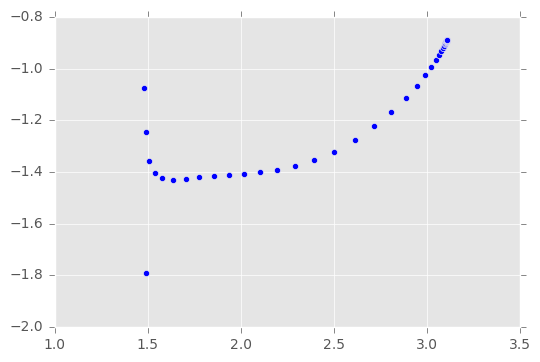

In [98]:
for _ in range(100):
    
    tmp_pi = [0, 0]
    tmp_theta = [[0, 0], [0, 0]]
    
    
    for wi in range(2):
        tmp_pi[wi] = sum(p_w(wi, x, theta) for x in data) / n
        tmp_theta[wi][0] = sum(p_w(wi, x, theta) * x for x in data) / sum(p_w(wi, x, theta) for x in data)
        tmp_theta[wi][1] = sum(p_w(wi, x, theta) * (x - theta[wi][0]) ** 2 for x in data) / sum(p_w(wi, x, theta) for x in data)
  
    pi1.append(pi[0])
    pi2.append(pi[1])
    
    
    # ここで一気に更新するとおかしくなる
    pi = tmp_pi
    theta = tmp_theta
    
    pyplot.scatter(theta[0][0], theta[1][0])

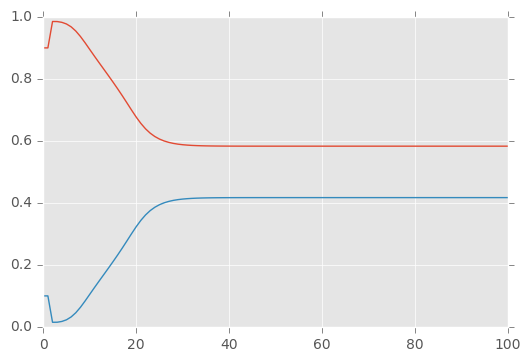

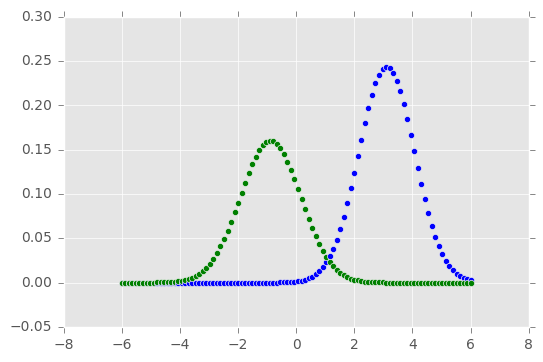

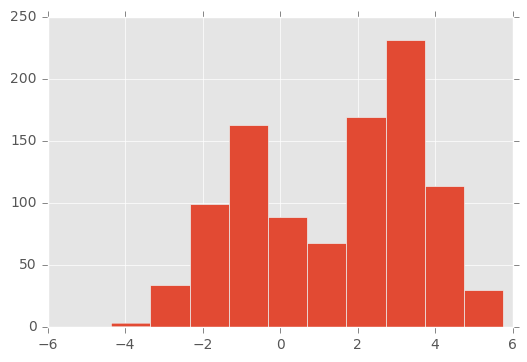

In [104]:
pyplot.plot(pi1)
pyplot.plot(pi2)
pyplot.show()

for x in numpy.linspace(-6, 6, 100):
    pyplot.scatter(x, pi[0] * p_x(x, 0, theta), c='b')
    pyplot.scatter(x, pi[1] * p_x(x, 1, theta), c='g')
    
pyplot.show()
pyplot.hist(data)
pyplot.show()

# クラスタリング

In [57]:
num_k = 2
mu_list = numpy.zeros((2, 2))
cov_list = list(numpy.zeros((2, 2)) for _ in range(num_k))
mu_list[0] = [0, 0]
mu_list[1] = [10, 10]
cov_list[0] = [[1, 0], [0, 1]]
cov_list[1] = [[1, 0], [0, 1]]

data1 = numpy.random.multivariate_normal(mu_list[0], cov_list[0], 100)
data2 = numpy.random.multivariate_normal(mu_list[1], cov_list[1], 100)
data = numpy.vstack((data1, data2))

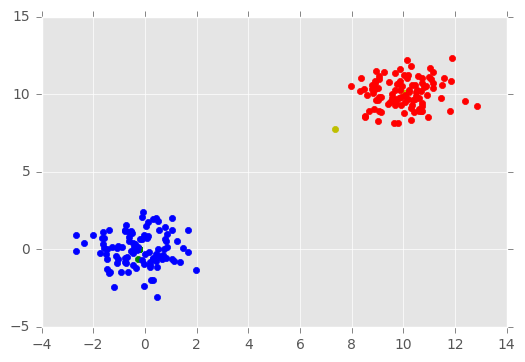

In [71]:
# K-Means

prototype = numpy.random.random((num_k, 2))
delta = numpy.zeros((num_k, len(data)))

for _ in range(100):

    # Assign
    for i, x in enumerate(data):
        j = numpy.argmin([numpy.linalg.norm(x - p) for p in prototype])

        if j == 0:
            delta[0][i] = 1
            delta[1][i] = 0
        elif j == 1:
            delta[0][i] = 0
            delta[1][i] = 1
        
    # Maximizing
    for i in range(len(prototype)):
        numerator = sum(delta[i][k] * data[k] for k in range(len(data)))
        n = sum(delta[i][k] for k in range(len(data)))
        prototype[i] = numerator / n

    for i, c in enumerate(['y', 'g']):
        pyplot.scatter(prototype[i][0], prototype[i][1], color=c)
        
for i, x in enumerate(data):
    if delta[0][i] == 0:
        pyplot.scatter(x[0], x[1], color='b')
    elif delta[1][i] == 0:
        pyplot.scatter(x[0], x[1], color='r')

# ノンパラメトリックベイズモデル

### Hoppe's urn mofdel

\begin{align}
\alpha \mid \alpha > 0
\end{align}

This parameter indicates the weight of black boll


The weights of other sort of bolls are one

### Chinese Restaurant Process

CRP is based on Hoppe's urn model


\begin{align}
black: \frac{\alpha}{n - 1 + \alpha} \\
other: \frac{n_i}{n - 1 + \alpha}
\end{align}

when n is small, probabilities are strange


### Pitman-Yor Process

Add parameter $\beta$ into CRP.

\begin{align}
\frac{(n_i - \beta)}{n - 1 + \alpha}
\end{align}

where c indicates the number of tables.
(if $ \beta $ is 0, this is CRP).

In [111]:
def trial(alpha = 10, n = 1000):
    def num_cluster():
        return len(urn.keys())
    
    num_type_of_bolls = list()
    urn = defaultdict(int)
    
    for num_iter in range(1, n):
        probabilities = [0] * (num_cluster() + 1)
        probabilities[0] = alpha / (num_iter - 1 + alpha)
        
        for i, num_points in enumerate(urn):
            probabilities[i+1] = urn[i+1] / (num_iter - 1 + alpha)
        
        sample_i = numpy.nonzero(numpy.random.multinomial(1, probabilities))[0][0]
        
        if sample_i == 0:
            urn[num_cluster() + 1] = 1
        else:
            urn[sample_i] += 1
            
        num_type_of_bolls.append(len(urn.keys()))
        
    return urn.values(), num_type_of_bolls

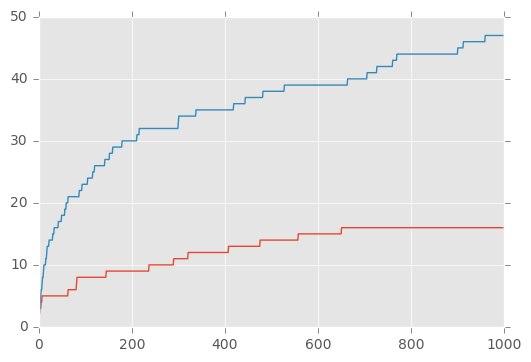

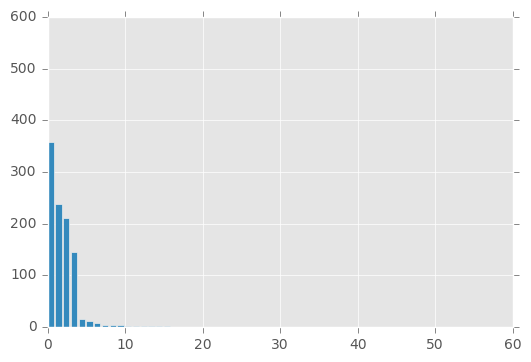

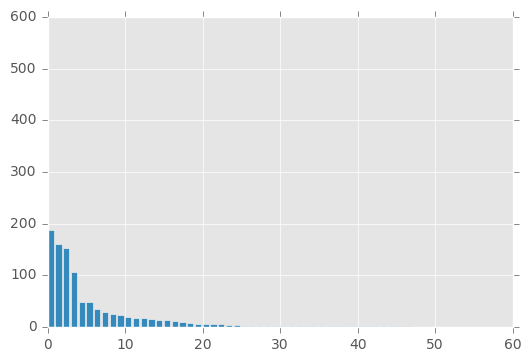

In [112]:
vals1, num_clusters = trial(alpha=2, n=1000)
pyplot.plot(num_clusters)
vals2, num_clusters = trial(alpha=10, n=1000)
pyplot.plot(num_clusters)
pyplot.show()

pyplot.bar(range(len(vals1)), sorted(vals1, reverse=1))
pyplot.xlim(0, 60)
pyplot.ylim(0, 600)
pyplot.show()

pyplot.bar(range(len(vals2)), sorted(vals2, reverse=1))
pyplot.xlim(0, 60)
pyplot.ylim(0, 600)
pyplot.show()

In [115]:
def trial(alpha = 10, n = 1000, beta = 0):
    def num_cluster():
        return len(urn.keys())
    
    num_type_of_bolls = list()
    urn = defaultdict(int)
    
    for num_iter in range(1, n):
        probabilities = [0] * (num_cluster() + 1)
        probabilities[0] = (alpha + beta * num_cluster()) / (num_iter - 1 + alpha)
        
        for i, num_points in enumerate(urn):
            probabilities[i+1] = (urn[i+1] - beta) / (num_iter - 1 + alpha)
        
        sample_i = numpy.nonzero(numpy.random.multinomial(1, probabilities))[0][0]
        
        if sample_i == 0:
            urn[num_cluster() + 1] = 1
        else:
            urn[sample_i] += 1
            
        num_type_of_bolls.append(len(urn.keys()))
        
    return urn.values(), num_type_of_bolls

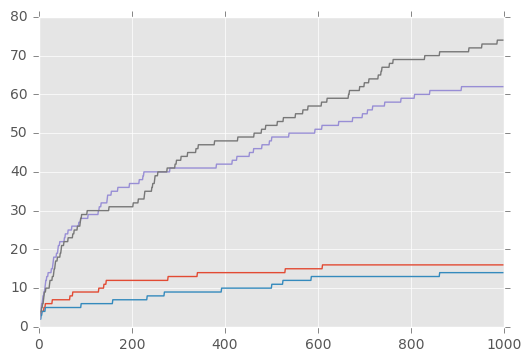

In [116]:
vals, num_clusters = trial(alpha=2, n=1000, beta = 0)
pyplot.plot(num_clusters)

vals, num_clusters = trial(alpha=2, n=1000, beta = 0.2)
pyplot.plot(num_clusters)

vals, num_clusters = trial(alpha=2, n=1000, beta = 0.3)
pyplot.plot(num_clusters)

vals, num_clusters = trial(alpha=2, n=1000, beta = 0.4)
pyplot.plot(num_clusters)

pyplot.show()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


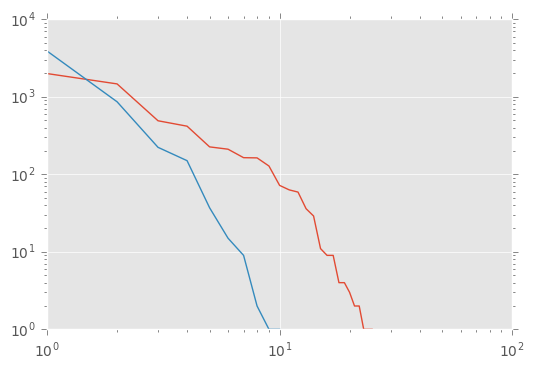

In [117]:
%time

vals1, _ = trial(alpha=2, n=10000, beta = 0.1)
vals2, _ = trial(alpha=2, n=10000, beta = 0)

pyplot.plot(sorted(vals1, reverse=1))
pyplot.plot(sorted(vals2, reverse=1))

pyplot.xscale('log')
pyplot.yscale('log')